<div style="color:white;
           display:fill;
           border-radius:70px;
           background-color:#735a8c;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:1px">

<p style="padding: 16px;
              color:white;"> 
    <center>
    <span style="font-size:40PX">
    <b>
using cgans in attack and product Mobile Crowdsensing system (MCS)
    </b>
        </span>
        </center>
</p>
</div>



<center><img src="https://miro.medium.com/max/1400/0*F-9UzpCOQlQtWi__.gif"><\center>

<div style="color:white;
           display:fill;
           border-radius:10px;
           background-color:#735a8c;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:1px">

<p style="padding: 16px;
              color:white;"> 
    <center>
    <span style="font-size:30PX">
    <b>
table of contant
    </b>
        </span>
        </center>
</p>
</div>

* [Project and dataset Overview](#1)
* [import liberaries](#2)
* [load dataset](#3)
* [clean and split dataset](#4)
	- [Features scaling](#5) 
	- [Split dataset](#6)
* [Fake task detection using classic ML algorithms](#7)
	- [Random Forest model training](#8)
	- [Adaboost model training](#9)
	- [Verify detection performance](#10)
* [build GAN model to generate fake task](#11)
	- [implement a CGAN model](#12)
	- [Apply the provided training dataset to CGAN](#13)
	- [Generate synthetic fake tasks via Generator network in CGAN](#14)
* [Use fake task generated by gan to attack the model](#15)
	- [Mix the generated fake tasks with the original test](#16)
	- [Obtain Adaboost and RF detection performance using the new test dataset](#17)
* [cascade detection framework to prodect the model](#18)
	- [Test the discriminator](#19)

<a id="1"></a> 
<div style="color:white;
           display:fill;
           border-radius:10px;
           background-color:#735a8c;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:1px">

<p style="padding: 16px;
              color:white;"> 
    <center>
    <span style="font-size:30PX">
    <b>
Project and dataset Overview
    </b>
        </span>
        </center>
</p>
</div>

## Project Overview
### whats mobile crowdsensing system is 

it is a technique where a large group of individuals having mobile devices capable of sensing and computing (such as smartphones, tablet computers, wearables) collectively share data and extract information to measure, map, analyze, estimate or infer (predict) any processes of common interest. In short, this means crowdsourcing of sensor data from mobile devices. 

### Project objective:

The objective of this project is to generate intelligent fake tasks by GAN. Meanwhile, you need to 
evaluate detection accuracy for original fake tasks and GAN-generated fake tasks. Detection 
mechanisms contains classic machine learning (ML) models (e.g., Random Forest (RF) and Adaboost) and 
a GAN-based cascade detection framework. Another objective is to compare traditional MLs and the 
cascade detection framework detection performance.


Traditional ML models (RF and Adaboost)-based detection methods are the same as assignment 2 which 
are considered as benchmarks. This project focuses on the GAN-based cascade framework which is 
demonstrated in Figure 1. The cascade framework is proposed that implements a two-level cascaded 
classifier architecture to predict the generated attack samples and original (empirically designed) attack 
samples and filter them before distributing them to MCS participants. 


The first level is formed by the GAN discriminator whereas the second level is a binary classifier. 
According to Figure 1, the training dataset is utilized to train binary classifiers (e.g., RF, Adaboost) and 
GAN. The training dataset includes original fake tasks. GANs take input samples of noise, and output 
adversarial (i.e., synthetic) samples. GAN consists of a Generator neural network and a Discriminator 
neural network. The role of the generator is to create synthetic samples as similar as the real ones 
whereas a Discriminator designs to distinguish real samples from the synthetic ones. The motive for the 
competition is to reduce the gap between generated samples for Generator and increase detection 
accuracy for Discriminator

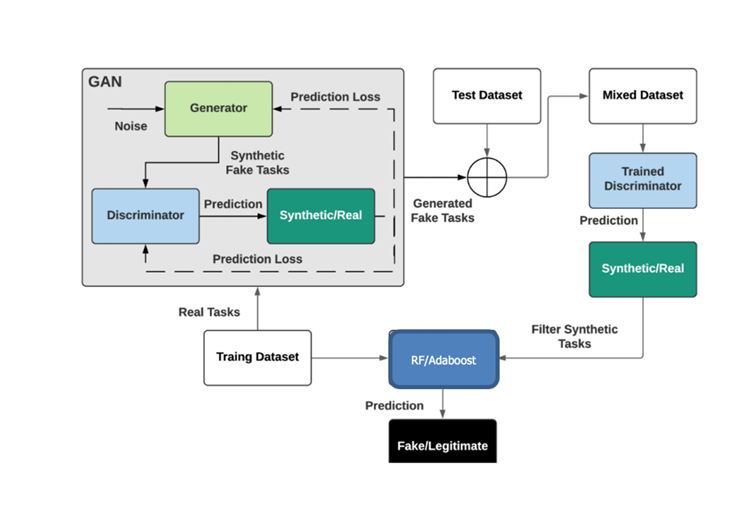

### Dataset

Dataset is generated by CrowdSenSim simulation tool. Dataset contains legitimate tasks and fake tasks. The task attributed are as follows: {’ID’, ’latitude’, ’longitude’, ’day’, ’hour’, ’minute’, ’duration’, ’remaining time’, ’battery requirement %’, ’Coverage’, ’legitimacy’, ’GridNumber’, ’OnpeakHour’}. 

Location of tasks are specified by ’latitude’ and ’longitude’ together. Furthermore, ’day’, ’hour’ and ’minute’ describe the task publish time. ’Duration’ denotes task active duration in terms of minutes. ’Remaining time’ denotes the residual time of a sensing task till its completion. ’Battery requirement’ is percentage of battery required to complete a task. ’Coverage’ denotes task sensing distance. ’Legitimacy’ describes whether a task is illegitimate one or legitimate one. This feature is used only in training of the machine learning models as the MCS platform is unaware of task legitimacy when a task is submitted. ’GridNumber’ is obtained by splitting sensing city map to small grids with numbers beginning at 1. ’OnpeakHour’ is a binary flag to indicate if task start time occurs during 7am to 11am. We define 7am to 11am as the peak hour and other hours are non-peak for the sake of simplicity in simulations. the dataset is created including total 14,484 tasks, with 12,587 legitimate tasks and 1,897 fake tasks, respectively.

### citation 

[1] Chen, Zhiyan, Murat Simsek, and Burak Kantarci. "Region-Aware Bagging and Deep Learning-Based Fake Task Detection in Mobile Crowdsensing Platforms." GLOBECOM 2020-2020 IEEE Global Communications Conference. IEEE, 2020. (2022).
[2] Mirza, Mehdi, and Simon Osindero. "Conditional generative adversarial nets." arXiv preprint arXiv:1411.1784 (2014).

<a id="2"></a> <br>
<div style="color:white;
           display:fill;
           border-radius:10px;
           background-color:#735a8c;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:1px">

<p style="padding: 16px;
              color:white;"> 
    <center>
    <span style="font-size:30PX">
    <b>
import liberaries
    </b>
        </span>
        </center>
</p>
</div>

In [101]:
!pip install session-info

In [102]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
import seaborn as sns # for data visualization
sns.reset_defaults()

from keras import backend as K

from keras.layers import Input, Dense, Reshape, Flatten, Concatenate
from keras.layers import BatchNormalization, Activation, Embedding, multiply
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D,Conv1D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical


from keras.utils.vis_utils import plot_model
from tensorflow import keras
from tensorflow.keras import layers


import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [103]:
from numpy.random import seed
seed(42)
tf.random.set_seed(42)

In [104]:
import session_info
session_info.show()

<a id="3"></a> <br>
<div style="color:white;
           display:fill;
           border-radius:10px;
           background-color:#735a8c;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:1px">

<p style="padding: 16px;
              color:white;"> 
    <center>
    <span style="font-size:30px;">
    <b>
 load dataset
    </b>
        </span>
        </center>
</p>
</div>

In [105]:
df=pd.read_csv('../input/mcsdatasetnextconlab/MCSDatasetNEXTCONLab.csv')
df

,ID,Latitude,Longitude,Day,Hour,Minute,Duration,RemainingTime,Resources,Coverage,OnPeakHours,GridNumber,Ligitimacy
0,1,45.442142,-75.303369,1,4,13,40,40,9,91,0,131380,1
1,1,45.442154,-75.304366,1,4,23,40,30,9,91,0,131380,1
2,1,45.442104,-75.303963,1,4,33,40,20,9,91,0,121996,1
3,1,45.441868,-75.303577,1,4,43,40,10,9,91,0,121996,1
4,2,45.447727,-75.147722,2,15,49,30,30,5,47,0,140784,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14479,3999,45.445303,-75.165596,2,1,18,20,20,10,80,0,131397,1
14480,3999,45.445574,-75.165168,2,1,28,20,10,10,80,0,131397,1
14481,4000,45.436682,-75.152416,0,12,21,30,30,4,63,0,122015,1
14482,4000,45.436978,-75.153278,0,12,31,30,20,4,63,0,122015,1


<a id="4"></a> <br>
<div style="color:white;
           display:fill;
           border-radius:10px;
           background-color:#735a8c;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:1px">

<p style="padding: 16px;
              color:white;"> 
    <center>
    <span style="font-size:30px;">
    <b>
clean and split dataset
    </b>
        </span>
        </center>
</p>
</div>

In [106]:
df=df.drop('ID',axis=1)

In [107]:
df['Ligitimacy'].value_counts()

1    12587
0     1897
Name: Ligitimacy, dtype: int64

<a id="5">
<font color=#735a8c size=32px>Features scaling</font>

In [108]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
scaler = StandardScaler()
X=scaler.fit_transform(X)


<a id="6">
<font color=#735a8c size=32px>Split dataset</font>
    
    
split dataset 80% for training and 20% for testing

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(X_train.shape)
print(X_test.shape)

(11587, 11)
(2897, 11)


<a id="7"></a> <br>
<div style="color:white;
           display:fill;
           border-radius:10px;
           background-color:#735a8c;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:1px">

<p style="padding: 16px;
              color:white;"> 
    <center>
    <span style="font-size:30px;">
    <b>
Fake task detection using classic ML algorithms
    </b>
        </span>
        </center>
</p>
</div>

<a id="8">
<font color=#735a8c size=86px>Random Forest model training</font>

In [110]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

<a id="9">
<font color=#735a8c size=86px>Adaboost model training </font>

In [111]:
adaboost = AdaBoostClassifier(n_estimators=100, random_state=0)
adaboost.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100, random_state=0)

<a id="10">
<font color=#735a8c size=86px>Verify detection performance</font>

In [112]:
def test_and_compare(models,x_test,y_test,labels1 = ['Fake', 'Legitimate' ],title='campare between models'):
  models_name=[]
  Accuracies=[]
  for model in models:
    print("Evaluated {} model".format(model))
    models_name.append(str(model))
    y_pred=model.predict(x_test)
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels1)
    disp.plot()
    plt.show()
    Accuracies.append(accuracy_score(y_test, y_pred)*100)
  plt.figure(figsize=(20,10))
  ax=sns.barplot(x=models_name, y=Accuracies)
  ax.set_title(title, size=26)
  counter=0
  for value in Accuracies:

    v=str(np.round(value,2))+' %'
    
    ax.text(counter,value,v, color='black', ha="center")
    counter+=1
  mi=min(Accuracies)
  ma=max(Accuracies)
  range=ma-mi
  
  plt.ylim(mi-(range), ma+range)
  plt.show()

Evaluated RandomForestClassifier() model
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       379
           1       0.99      1.00      1.00      2518

    accuracy                           1.00      2897
   macro avg       1.00      0.98      0.99      2897
weighted avg       1.00      1.00      1.00      2897



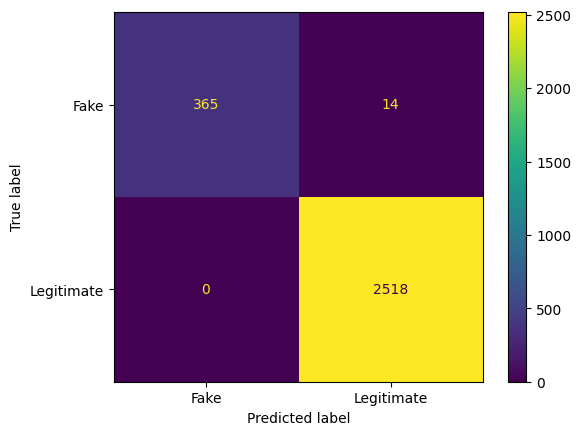

Evaluated AdaBoostClassifier(n_estimators=100, random_state=0) model
              precision    recall  f1-score   support

           0       0.89      0.82      0.85       379
           1       0.97      0.98      0.98      2518

    accuracy                           0.96      2897
   macro avg       0.93      0.90      0.92      2897
weighted avg       0.96      0.96      0.96      2897



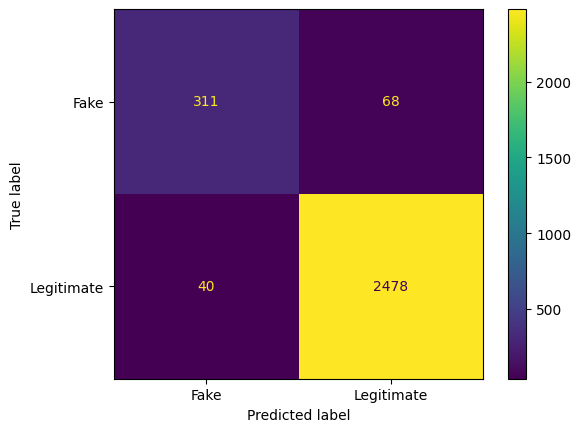

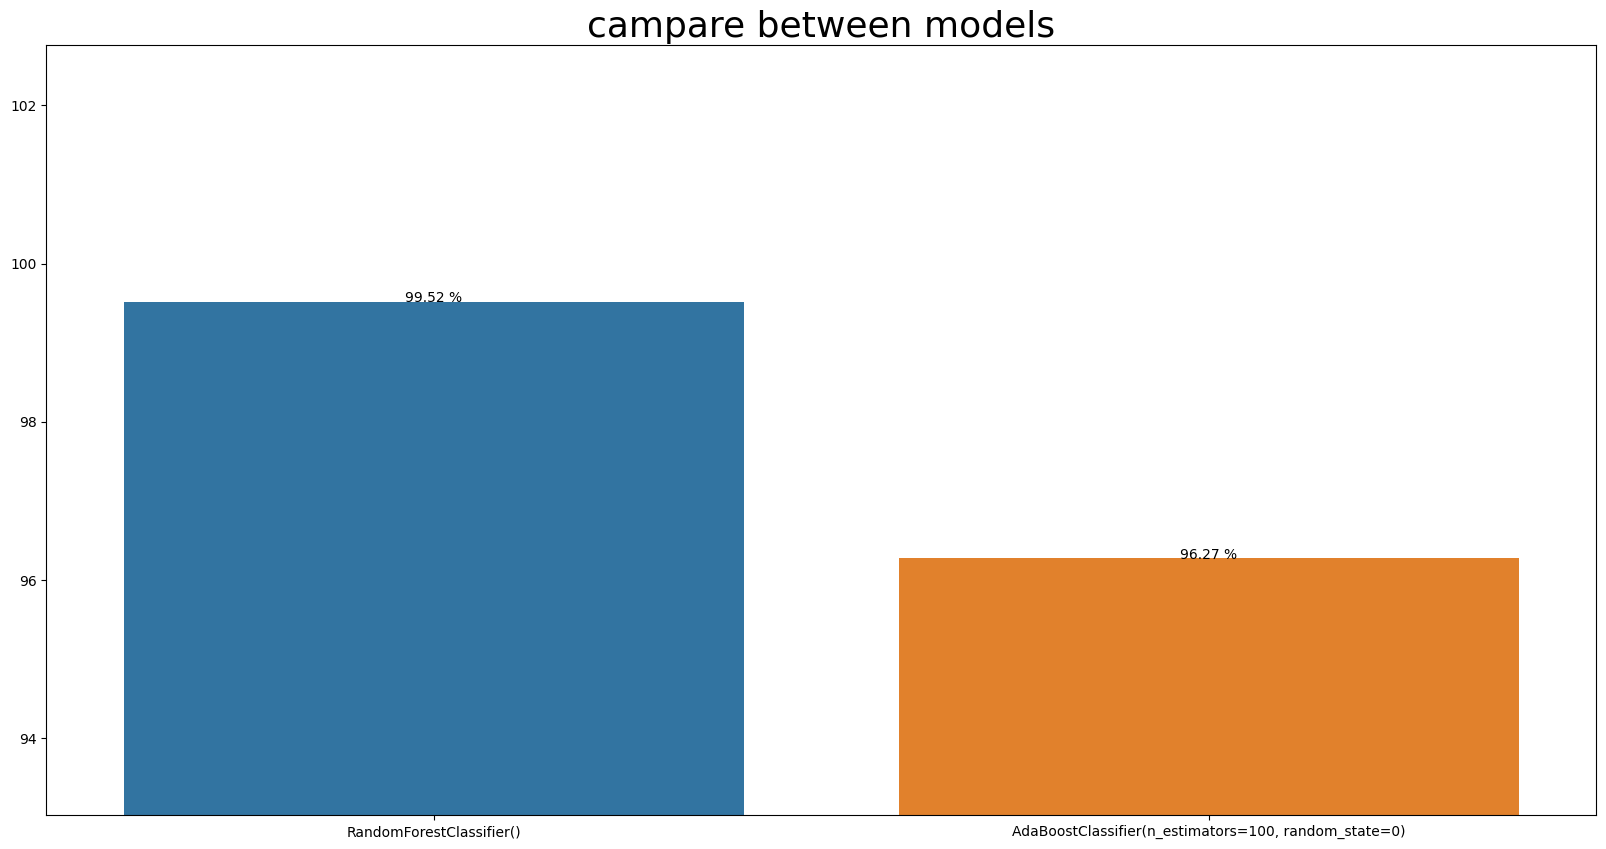

In [113]:
test_and_compare([rf,adaboost],X_test,y_test)

<a id="11"></a> <br>
<div style="color:white;
           display:fill;
           border-radius:10px;
           background-color:#735a8c;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:1px">

<p style="padding: 16px;
              color:white;"> 
    <center>
    <span style="font-size:30px;">
    <b>
build GAN model to generate fake task 
    </b>
        </span>
        </center>
</p>
</div>

<center><img src="https://datasysbd.com/wp-content/uploads/2018/07/cs-an.gif"></center>



in cybersecerity In a red team/blue team cybersecurity simulation, the red team acts as an adversary, attempting to identify and exploit potential weaknesses within the organization’s cyber defenses using sophisticated attack techniques. These offensive teams typically consist of highly experienced security professionals or independent ethical hackers who focus on penetration testing by imitating real-world attack techniques and methods.


The red team gains initial access usually through the theft of user credentials or social engineering techniques. Once inside the network, the red team elevates its privileges and moves laterally across systems with the goal of progressing as deeply as possible into the network, exfiltrating data while avoiding detection.

 <span style="font-size:30px; color:red;"> in this project the red team try to attack  crowdsensing system by generate fake tasks</span>
 <center><img src="https://miro.medium.com/max/1220/1*0ZKEDrwU-_wkg_0CQsMuYA.png"></center>

<a id="12">
<font color=#735a8c size=86px>implement a CGAN model</font>

In [114]:
n_classes=2
batch_size = 64
num_channels = 1
row_size = 11
latent_dim = 128
dis_input=num_channels+n_classes
generator_in_channels=latent_dim+n_classes

In [115]:
discriminator = keras.Sequential(
    [    
        keras.layers.InputLayer((11,dis_input)),
        keras.layers.Flatten(),
        #layers.Conv1D(64, 3, strides=2, padding="same"),
        #layers.LeakyReLU(alpha=0.2),
        #layers.GlobalMaxPooling1D(),

        Dense(64),
        layers.LeakyReLU(alpha=0.2),
        Dense(128),
        layers.LeakyReLU(alpha=0.2),
        Dense(256),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.2),

        Dense(1, activation='sigmoid')
    ],
    name="discriminator",
)

# Create the generator.
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels)),
        layers.Dense(11 * generator_in_channels),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((11, generator_in_channels)),
        layers.Dense(128),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Dense(128),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Dense(256),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(1, activation="sigmoid"),
        layers.Reshape((11, 1)),
    ],
    name="generator",

)


In [116]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 33)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 64)                2176      
_________________________________________________________________
leaky_re_lu_39 (LeakyReLU)   (None, 64)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 128)               8320      
_________________________________________________________________
leaky_re_lu_40 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_41 (LeakyReLU)   (None, 256)             

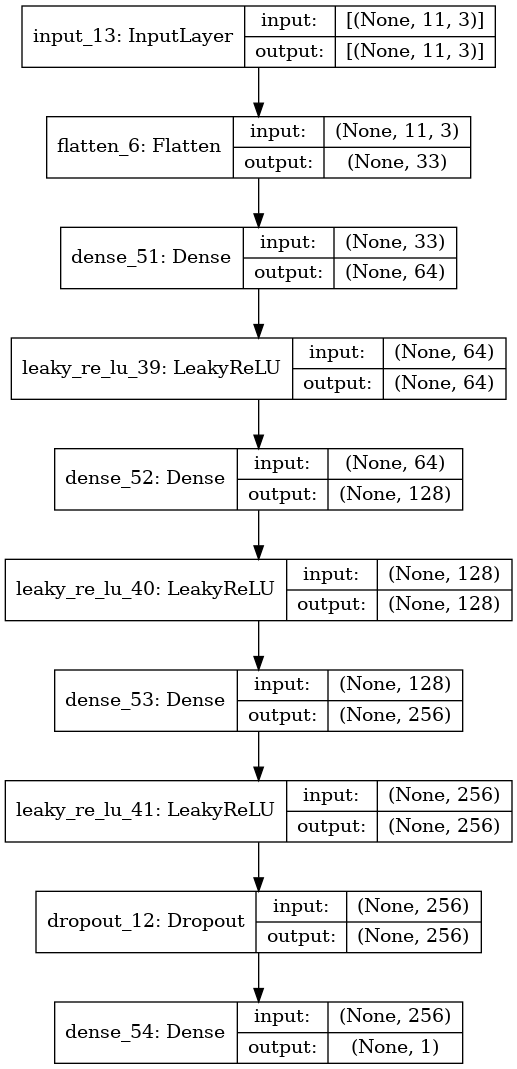

In [117]:
plot_model(discriminator, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [118]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 1430)              187330    
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 1430)              0         
_________________________________________________________________
reshape_12 (Reshape)         (None, 11, 130)           0         
_________________________________________________________________
dense_56 (Dense)             (None, 11, 128)           16768     
_________________________________________________________________
leaky_re_lu_43 (LeakyReLU)   (None, 11, 128)           0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 11, 128)           512       
_________________________________________________________________
dense_57 (Dense)             (None, 11, 128)           16

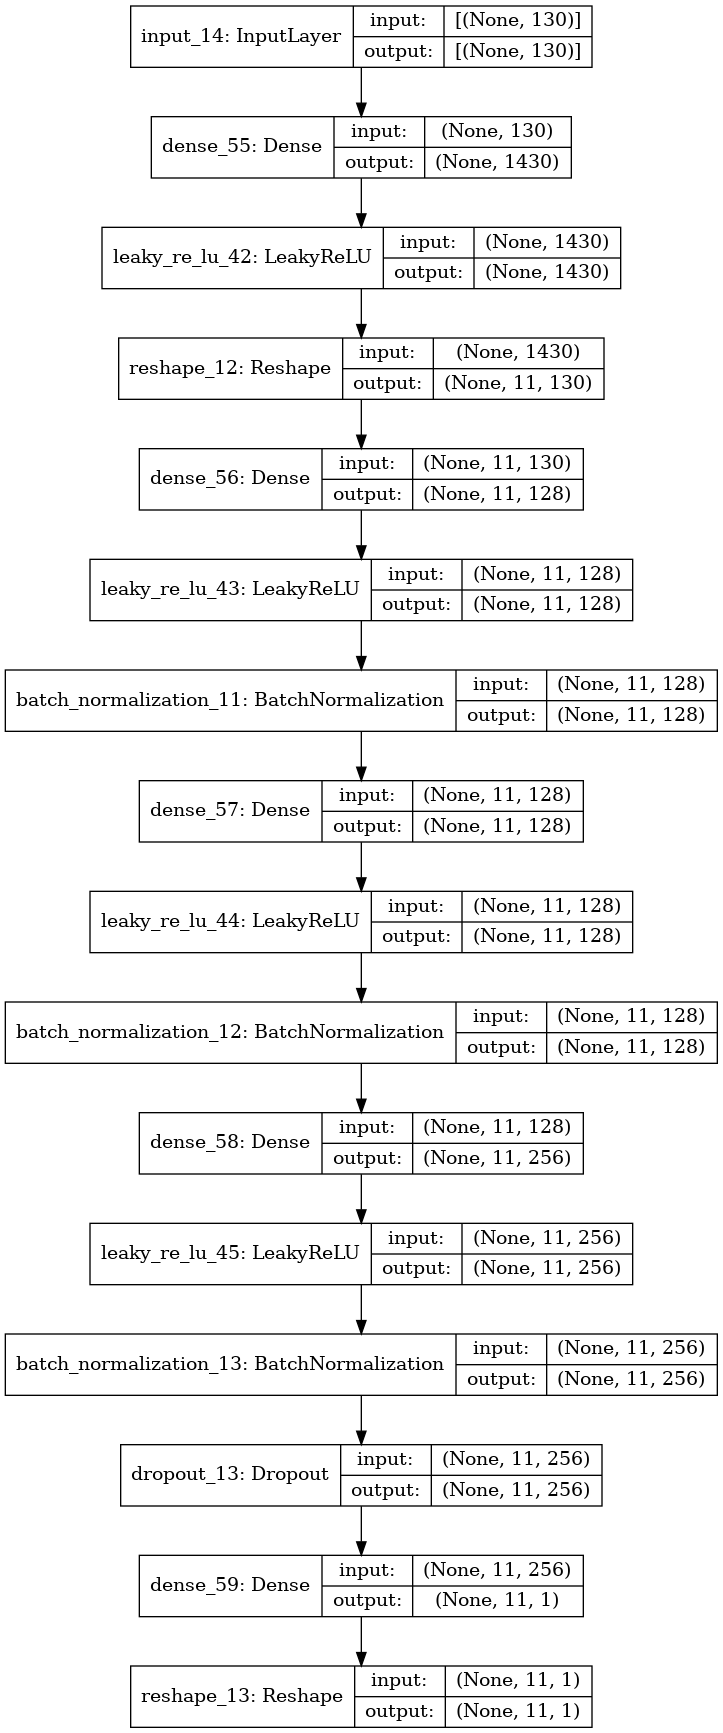

In [119]:
plot_model(generator, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [120]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):

        real_data, one_hot_labels = data

        row_one_hot_labels = one_hot_labels[:, None, None]
        row_one_hot_labels = tf.repeat(
            row_one_hot_labels, repeats=[row_size]
        )
        row_one_hot_labels = tf.reshape(
            row_one_hot_labels, (-1, row_size, n_classes)
        )
        #    nx11x2
        batch_size = tf.shape(real_data)[0]
        #    n
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        #    nx128
        

        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )
        #  nx128 + nx2= nx130

        generated_row = self.generator(random_vector_labels)
        #   nx11X1

        fake_and_labels = tf.concat([generated_row, row_one_hot_labels], -1)

        # nx11x1 +nx11x2 =nx11x3
        real_and_labels = tf.concat([real_data, row_one_hot_labels], -1)
        # nx11x1 +nx11x2 =nx11x3
        combined_data = tf.concat(
            [fake_and_labels, real_and_labels], axis=0
        )
        # nx11x3
        labels = tf.concat(
            [tf.zeros((batch_size,1)),tf.ones((batch_size,1))], axis=0
        )
        # 2nx2
        # 0 for generator and 1 for real
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_data)
            d_loss = self.loss_fn(labels, predictions)
        # train discriminator
        
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )


        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat( 
            [random_latent_vectors, one_hot_labels], axis=1
        )

        #nx130

        misleading_labels = tf.ones((batch_size,1))
        # nx2 all ones
        with tf.GradientTape() as tape:
            fake_data = self.generator(random_vector_labels)
            fake_and_labels = tf.concat([fake_data, row_one_hot_labels], -1)
            predictions = self.discriminator(fake_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)

        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

<a id="13">
<font color=#735a8c size=86px>Apply the provided training dataset to CGAN</font>

In [121]:
# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
all_digits = np.reshape(X_train, (-1, 11)).astype('float32')
all_digits=np.array(all_digits).reshape(-1,11,1)
all_labels = keras.utils.to_categorical(y_train, 2)
#all_labels=np.array(y_train,dtype="float32").reshape(-1,1)
# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {all_digits.shape}")
print(f"Shape of training labels: {all_labels.shape}")

Shape of training images: (11587, 11, 1)
Shape of training labels: (11587, 2)


In [122]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.01),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

cond_gan.fit(dataset, epochs=10)

Epoch 1/10


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4994: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


182/182 [==============================] - 3s 6ms/step - g_loss: 6.6205 - d_loss: 0.1100
Epoch 2/10
182/182 [==============================] - 1s 6ms/step - g_loss: 10.1993 - d_loss: 3.9145e-05
Epoch 3/10
182/182 [==============================] - 1s 6ms/step - g_loss: 11.4253 - d_loss: 7.7779e-06
Epoch 4/10
182/182 [==============================] - 1s 6ms/step - g_loss: 11.9762 - d_loss: 4.2891e-06
Epoch 5/10
182/182 [==============================] - 2s 10ms/step - g_loss: 12.4328 - d_loss: 2.8885e-06
Epoch 6/10
182/182 [==============================] - 1s 7ms/step - g_loss: 12.8012 - d_loss: 1.9732e-06
Epoch 7/10
182/182 [==============================] - 1s 6ms/step - g_loss: 13.1231 - d_loss: 1.4611e-06
Epoch 8/10
182/182 [==============================] - 1s 6ms/step - g_loss: 13.4002 - d_loss: 1.0747e-06
Epoch 9/10
182/182 [==============================] - 1s 6ms/step - g_loss: 13.6355 - d_loss: 9.0790e-07
Epoch 10/10
182/182 [==============================] - 1s 6ms/step - g

<a id="14">
<font color=#735a8c size=86px>Generate synthetic fake tasks via Generator network in CGAN</font>

In [123]:
trained_gen = cond_gan.generator
trained_dic=cond_gan.discriminator
num_interpolation =   X_test.shape[0]

# Sample noise for the interpolation.
interpolation_noise = tf.random.normal(shape=(1, latent_dim))
interpolation_noise = tf.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = tf.reshape(interpolation_noise, (num_interpolation, latent_dim))

interpolation_labels = keras.utils.to_categorical([1]*num_interpolation, 2)
interpolation_labels = tf.reshape(interpolation_labels, (num_interpolation, 2))
noise_and_labels = tf.concat([interpolation_noise, interpolation_labels], axis=1)

fake = trained_gen.predict(noise_and_labels)

<a id="15"></a> <br>
<div style="color:white;
           display:fill;
           border-radius:10px;
           background-color:#735a8c;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:1px">

<p style="padding: 16px;
              color:white;"> 
    <center>
    <span style="font-size:30px;">
    <b>
Use fake task generated by gan to attack the model  
    </b>
        </span>
        </center>
</p>
</div>

<a id="16">
<font color=#735a8c size=32px>Mix the generated fake tasks with the original test </font>


In [124]:
mixed_data=np.concatenate((np.array(X_test), fake.reshape(-1,11)), axis=0)
mixed_y=np.concatenate((np.array(y_test), [0]*y_test.shape[0]), axis=0)

In [125]:
mixed_data.shape

(5794, 11)

In [126]:
mixed_y.shape

(5794,)

<a id="17">
<font color=#735a8c size=32px>Obtain Adaboost and RF detection performance using the new test dataset</font>

Evaluated RandomForestClassifier() model
              precision    recall  f1-score   support

           0       1.00      0.11      0.20      3276
           1       0.46      1.00      0.63      2518

    accuracy                           0.50      5794
   macro avg       0.73      0.56      0.42      5794
weighted avg       0.77      0.50      0.39      5794



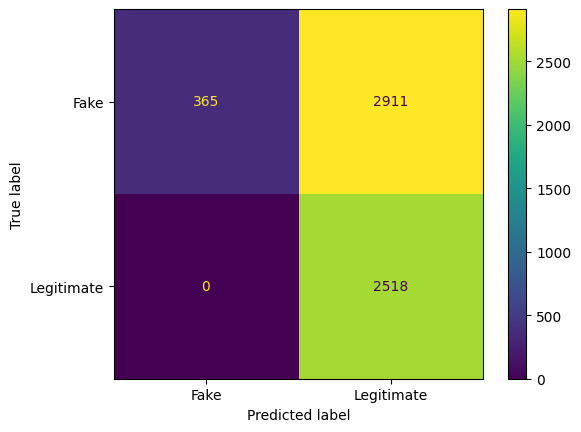

Evaluated AdaBoostClassifier(n_estimators=100, random_state=0) model
              precision    recall  f1-score   support

           0       0.89      0.09      0.17      3276
           1       0.46      0.98      0.62      2518

    accuracy                           0.48      5794
   macro avg       0.67      0.54      0.40      5794
weighted avg       0.70      0.48      0.37      5794



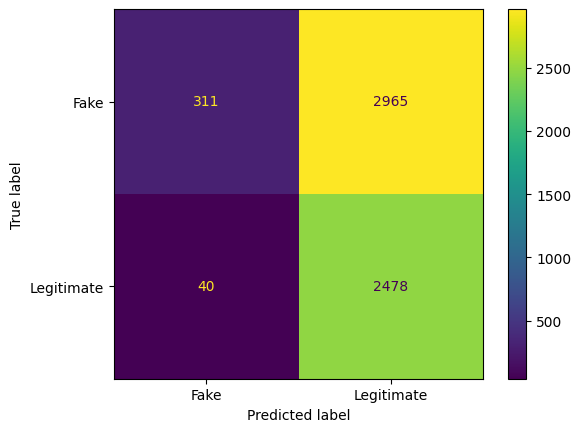

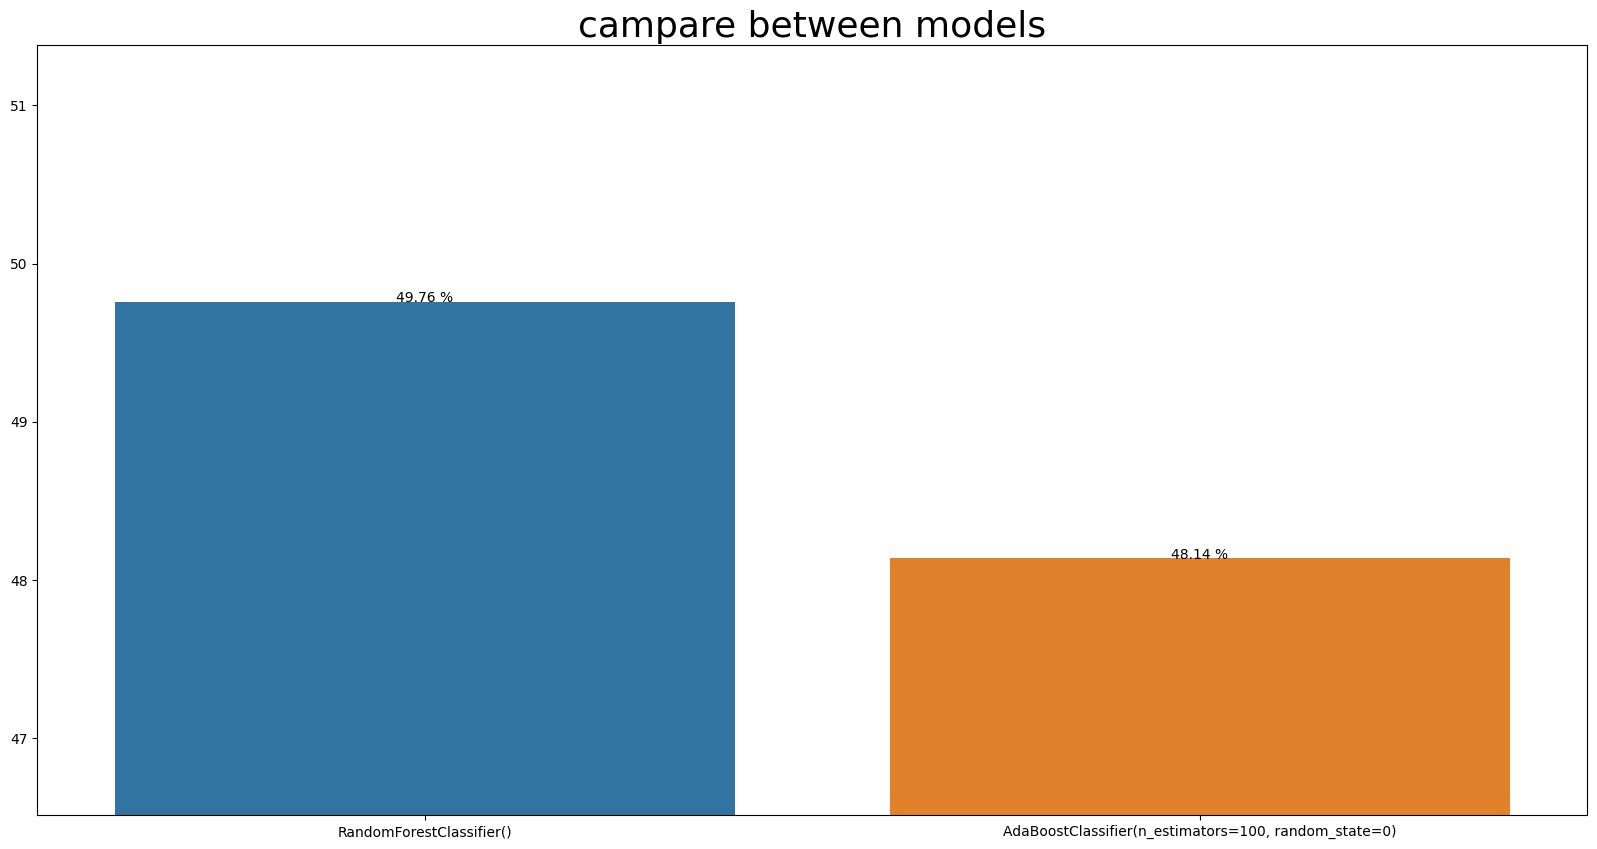

In [127]:
test_and_compare([rf,adaboost],mixed_data,mixed_y)

<a id="18"></a> <br>
<div style="color:white;
           display:fill;
           border-radius:10px;
           background-color:red;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:1px">

<p style="padding: 16px;
              color:white;"> 
    <center>
    <span style="font-size:30px;">
    <b>
cascade detection framework to prodect the model  
    </b>
        </span>
        </center>
</p>
</div>

<center><img src="https://deflect.ca/wp-content/uploads/2021/01/Hero-1_v2_GIF_rbg32_noDither_60fps.gif"></center>

<a id="19">
<font color=#735a8c size=32px>Test the discriminator</font>


In [128]:
y_true_pred=np.concatenate([[1]*y.shape[0],[0]*fake.shape[0]])
y_true_pred.shape

(17381,)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2897
           1       1.00      1.00      1.00     14484

    accuracy                           1.00     17381
   macro avg       1.00      1.00      1.00     17381
weighted avg       1.00      1.00      1.00     17381



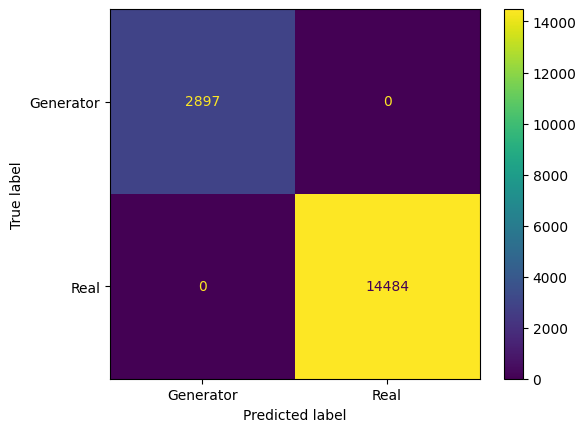

In [129]:
rows = np.reshape(X, (-1, 11)).astype('float32')
rows = np.array(rows).reshape(-1,11,1)
all_labels = keras.utils.to_categorical(y, 2)


one_hot_labels = all_labels[:, None, None]

one_hot_labels = tf.repeat(
    one_hot_labels, repeats=[row_size]
)

one_hot_labels = tf.reshape(
    one_hot_labels, (-1, row_size, n_classes)
)
# N X 11 X n
data_and_labels = tf.concat([rows, one_hot_labels], -1)

all_labels = keras.utils.to_categorical([0]*fake.shape[0], 2)


one_hot_labels = all_labels[:, None, None]

one_hot_labels = tf.repeat(
    one_hot_labels, repeats=[row_size]
)

one_hot_labels = tf.reshape(
    one_hot_labels, (-1, row_size, n_classes)
)

fake_and_labels = tf.concat([fake,one_hot_labels], -1)

# nx11x1 +nx11x2 =nx11x3

combined_data = tf.concat(
    [data_and_labels,fake_and_labels], axis=0
)

fake_test=trained_dic.predict(combined_data) 

y_pred=np.array([ 1 if x>0.5 else 0 for x in fake_test])
print(classification_report(y_true_pred, y_pred))
cm = confusion_matrix(y_true_pred, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Generator','Real'])
disp.plot()
plt.show()


In [130]:
def cascade_detection_framework(models,trained_dic,X,Y):
  rows = np.reshape(X, (-1, 11)).astype('float32')
  rows = np.array(rows).reshape(-1,11,1)
  all_labels = keras.utils.to_categorical(Y, 2)


  one_hot_labels = all_labels[:, None, None]

  one_hot_labels = tf.repeat(
      one_hot_labels, repeats=[row_size]
  )

  one_hot_labels = tf.reshape(
      one_hot_labels, (-1, row_size, n_classes)
  )
  # N X 11 X 2
  data_and_labels = tf.concat([rows, one_hot_labels], -1)
  fake_test=trained_dic.predict(data_and_labels) 

  y_pred=np.argmax(fake_test,axis=1)
  y_pred=np.array([ 1 if x>0.5 else 0 for x in fake_test])
  x_real=X[y_pred==1]
  y_real=Y[y_pred==1]

  test_and_compare(models,x_real,y_real)


Evaluated RandomForestClassifier() model
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       379
           1       0.99      1.00      1.00      2518

    accuracy                           1.00      2897
   macro avg       1.00      0.98      0.99      2897
weighted avg       1.00      1.00      1.00      2897



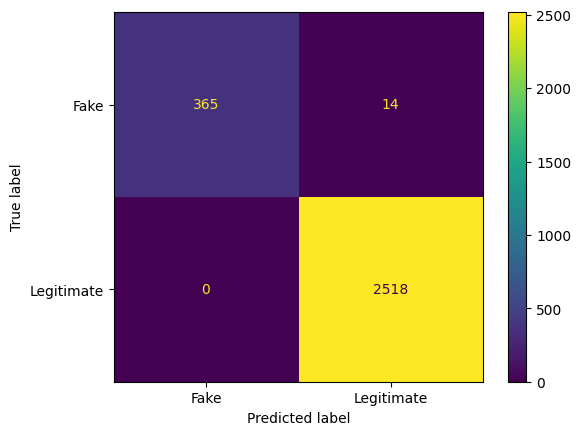

Evaluated AdaBoostClassifier(n_estimators=100, random_state=0) model
              precision    recall  f1-score   support

           0       0.89      0.82      0.85       379
           1       0.97      0.98      0.98      2518

    accuracy                           0.96      2897
   macro avg       0.93      0.90      0.92      2897
weighted avg       0.96      0.96      0.96      2897



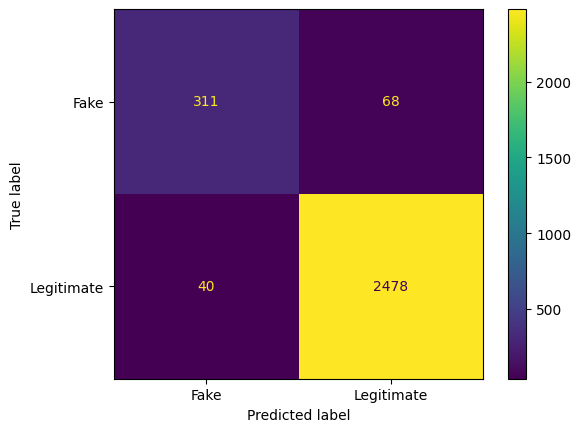

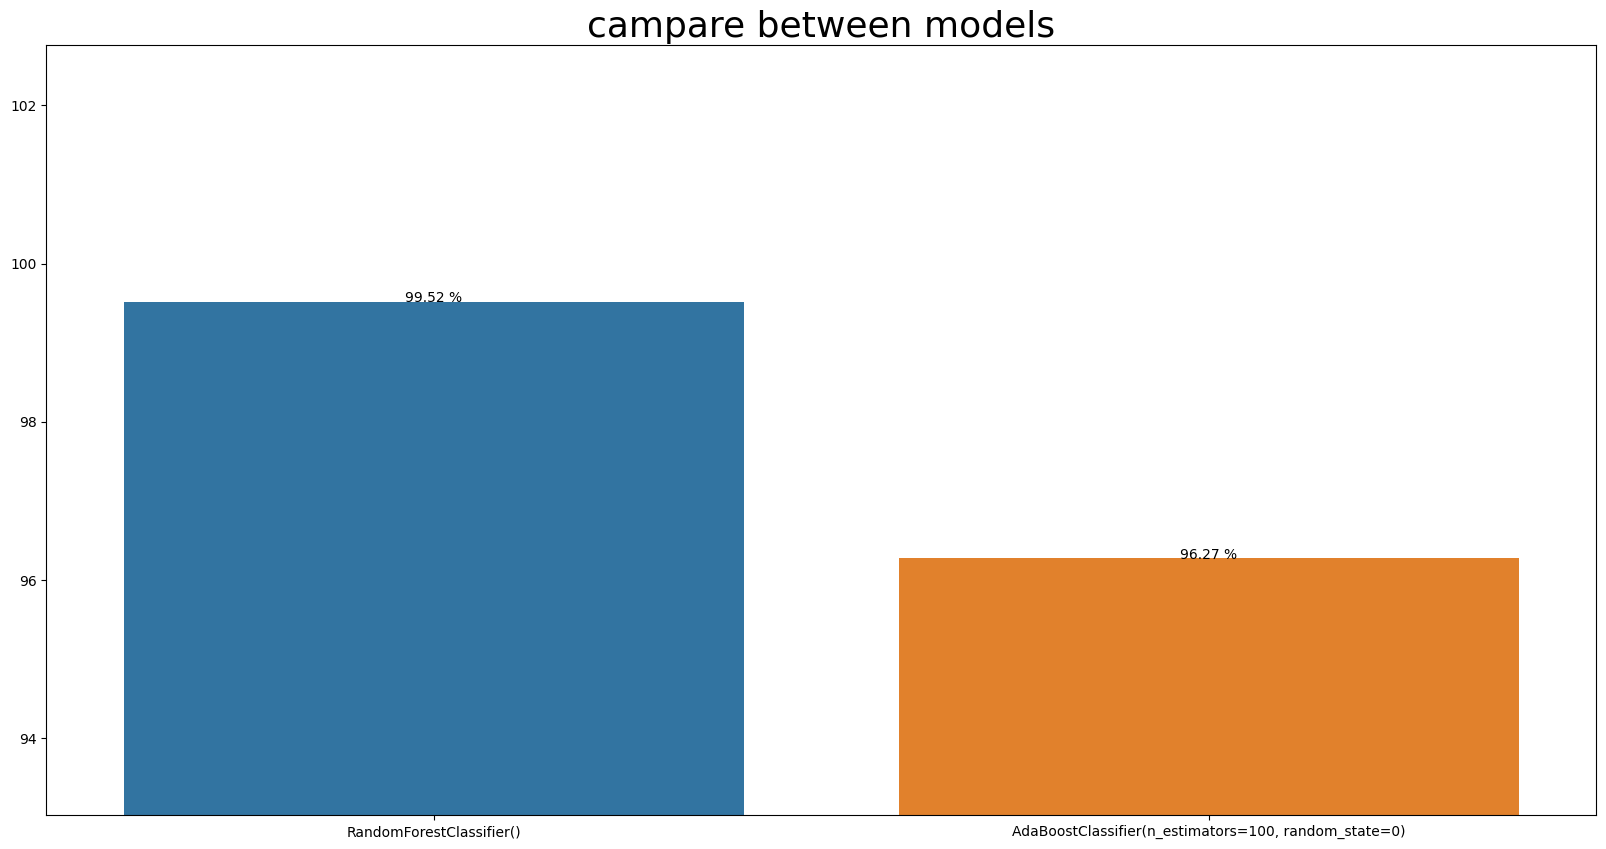

In [131]:
trained_dic=cond_gan.discriminator
cascade_detection_framework([rf,adaboost],trained_dic,mixed_data,mixed_y)

<a id="15"></a> <br>
<div style="color:white;
           display:fill;
           border-radius:10px;
           background-color:#735a8c;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:1px">

<p style="padding: 16px;
              color:white;"> 
    <center>
    <span style="font-size:30px;">
    <b>
Conclusion
    </b>
        </span>
        </center>
</p>
</div>


can assign having two teams the red team and blue team,the blue team used randam forest and adaboost to build detection fake tasks to product our crowdsensing system from scamming and he succeeded to detect almost 99% from fake tasks but the classifier is weak to detect advanced attack tecniques like gans so the red team try to attack the dection system using cgan and he succeeded to reduce the accuracy from 99% to 49% so the blue and red teams try to solves this risk throws use gan discriminator to filter any fake task created with gans and that help model to return the high accuracy and detect all fake created randam and created with advaced techniques

<div style=" display:fill;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:1px;
           border: 8px solid red;
           border-radius: 40px;">

<p style="padding: 16px;"> 
    <center>
    <span style="font-size:30px;">
    <b>
please if you found this note is useful, also if you have more time you can view <a href="https://www.kaggle.com/mohamedbakhet">kaggle profile</a> and  <a href="https://github.com/mohamedbakhet">github profile</a>
    </b>
        </span>
        <br>
        <br>
        <div>
        <img src="https://i.imgur.com/tUt3jGI.gif">
         </div>
        </center>
</p>
</div>

<center><img src="https://i.pinimg.com/originals/04/3a/fa/043afa3ad106b8ca83ea44b21036d2f9.gif"></center>